In [1]:
import os
import csv
import time
import numpy as np
import pandas as pd
from sonnmf.main import sonnmf
from sonnmf.old.main import sonnmf as sonnmf_old
import matplotlib.pyplot as plt

In [2]:
def save_results(filepath, W, H, fscores, gscores, hscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

def save_results_old(filepath, W, H, fscores, gscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, total_scores=total_scores)

def load_results_old(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['total_scores']

In [3]:
csv_filename = "../saved_models/runtime_comparison/results.csv"

if not os.path.exists(csv_filename):
    with open(csv_filename, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Dataset' ,'Method', 'Time Taken', 'Save Filepath'])


In [4]:
w_solvers = ['proximal_avg_with_penalty_func', 'admm', 'nesterov_smoothing']
w_legend = ['Proximal Avg. w/ penalty', 'ADMM', 'Nesterov Smoothing']
linech = ['-', '--', ':']


## synthetic (r=8)

In [60]:
data_filepath = '../datasets/synthetic_data.npz'
ini_filepath = '../saved_models/synthetic/r{}_ini.npz'

In [61]:
if os.path.exists(data_filepath):
    data = np.load(data_filepath)
    M = data['M']
    W_true = data['W_true']
    H_true = data['H_true']


In [62]:
dataset_name = 'sythetic_r8'
m, n = M.shape
r = 8

max_iters = 1000
_lam = 1e-6
_gamma = 1.5

In [63]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [64]:
# Proximal averaging with penalty term

save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'

if not os.path.exists(save_filepath):
    start_time = time.time()
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    time_taken = time.time() - start_time
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

    with open(csv_filename, 'a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([dataset_name , w_solvers[0], time_taken, save_filepath])

In [65]:
for w_solver in w_solvers[1:]:
    save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solver}.npz'

    if not os.path.exists(save_filepath):
        start_time = time.time()
        W, H, fscores, gscores, total_scores = sonnmf_old(M, ini_W.copy(), ini_H.copy(), lam=_lam, w_update_method=w_solver, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
        time_taken = time.time() - start_time
        save_results_old(save_filepath, W, H, fscores, gscores, total_scores)

        with open(csv_filename, 'a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([dataset_name , w_solver, time_taken, save_filepath])

In [66]:
all_total_scores = []

save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'
_, _, fscores, gscores, _, total_scores = load_results(save_filepath)
total_scores = fscores + _lam * gscores
all_total_scores.append(total_scores)

for i in range(1, len(w_solvers)):
    save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[i]}.npz'
    _, _, fscores, gscores, total_scores = load_results_old(save_filepath)
    all_total_scores.append(total_scores)

min_val = min([min(arr) for arr in all_total_scores])
max_val = max([max(arr) for arr in all_total_scores])

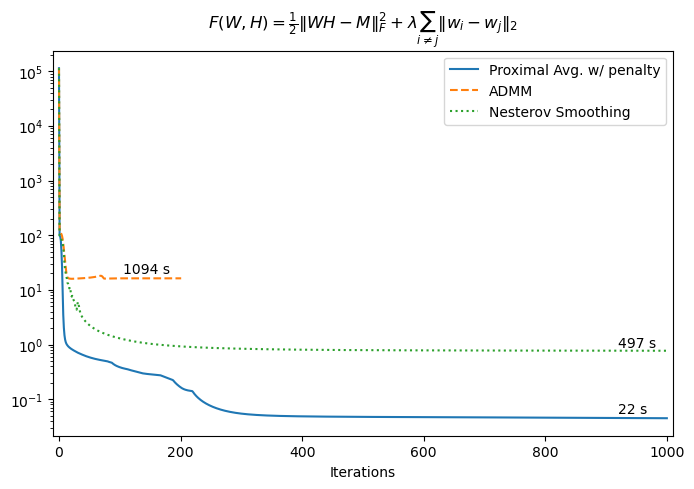

In [67]:

fig = plt.figure(figsize=(8, 5))  # Adjust the figsize accordingly
for i in range(len(w_solvers)):
    plt.plot(all_total_scores[i], linech[i])

plt.yscale('log')
plt.xlim(-10, 1010)

plt.legend(w_legend)
plt.xlabel('Iterations')
# plt.ylabel(r'$F(W, H)$')
plt.title(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2$')
# plt.title(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2 + \gamma \sum_{j=1}^r \left\| \max\{ -\mathbf{w}_j , \mathbf{0}\} \right\|_1 $')

plt.text(920, 0.055, '22 s')
# plt.text(920, 4.5, '21 s')
plt.text(105, 20, '1094 s')
plt.text(920, 0.9, '497 s')


plt.savefig(f'F_{dataset_name}.pdf', bbox_inches='tight')

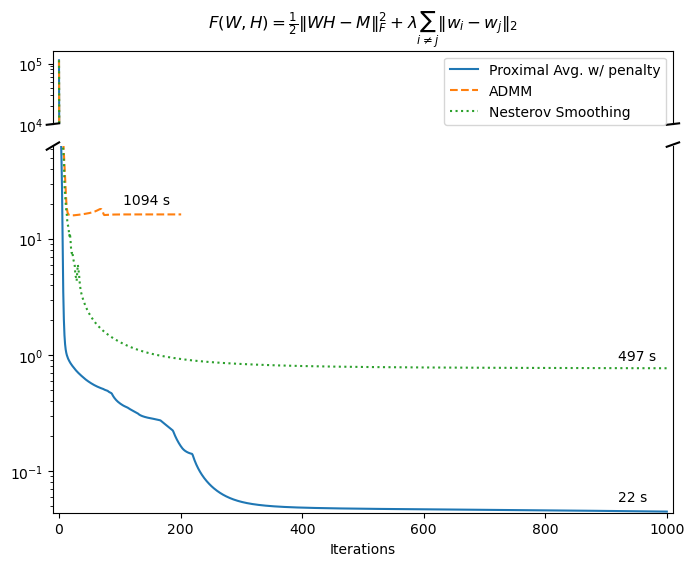

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 5]})

# Upper plot (top plot with y values < 10^2)
max_val, min_val = 0, 10**6
for i in range(len(w_solvers)):
    ax1.plot(all_total_scores[i], linech[i])

    if max(all_total_scores[i]) > max_val:
        max_val = max(all_total_scores[i])

    if min(all_total_scores[i]) < min_val:
        min_val = min(all_total_scores[i])

ax1.set_yscale('log')
ax1.set_ylim(10 ** 4, max_val + 50000)
ax1.set_xlim(-10, 1010)


for i in range(len(w_solvers)):
    ax2.plot(all_total_scores[i], linech[i])

ax2.set_yscale('log')
ax2.set_ylim(min_val - 0.001, 10 ** 1.8)
ax2.set_xlim(-10, 1010)

ax2.text(920, 0.055, '22 s')
ax2.text(105, 20, '1094 s')
ax2.text(920, 0.9, '497 s')

ax1.set_xticks([])

# Set labels and titles
ax2.set_xlabel('Iterations')
# ax2.set_ylabel(r'$F(W, H)$')
ax1.set_title(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2$')


ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax1.xaxis.tick_top() 
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d*0.2, 1 + d), **kwargs)  # bottom-right diagonal

fig.subplots_adjust(hspace=0.1)
ax1.legend(w_legend)

fig.savefig(f'F_{dataset_name}_broken_axis.pdf', bbox_inches='tight')

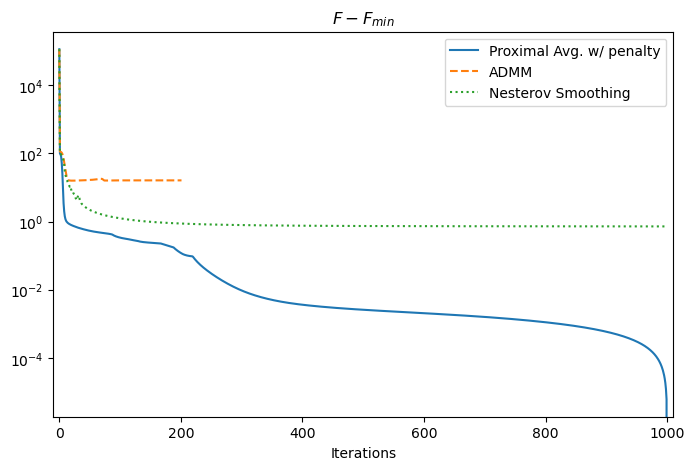

In [69]:
fig = plt.figure(figsize=(8, 5))  # Adjust the figsize accordingly

for i in range(len(w_solvers)):
    plt.plot(all_total_scores[i] - min_val, linech[i])

plt.xlim(-10, 1010)
plt.yscale('log')
plt.legend(w_legend)
plt.xlabel('Iterations')
plt.title(r'$F - F_{min}$')
# plt.title(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2$')
# plt.title(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2 + \gamma \sum_{j=1}^r \left\| \max\{ -\mathbf{w}_j , \mathbf{0}\} \right\|_1 $')


plt.savefig(f'F_Fmin_{dataset_name}.pdf', bbox_inches='tight')


## jasper region 1 (8 * 8)

In [38]:
data_filepath = '../datasets/jasper_region_1.npz'
ini_filepath = '../saved_models/jasper_region_1/r{}_ini.npz'

In [39]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape

In [40]:
dataset_name = 'jasper_region_1'
m, n = M.shape
r = n

max_iters = 2000
_lam = 40000
_gamma = 10000

In [41]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [42]:
# Proximal averaging with penalty term

save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'

if not os.path.exists(save_filepath):
    start_time = time.time()
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, max_minutes=240, W_update_iters=10, early_stop=True, verbose=False)
    time_taken = time.time() - start_time
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

    with open(csv_filename, 'a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([dataset_name , w_solvers[0], time_taken, save_filepath])

In [43]:
for w_solver in w_solvers[1:]:
    save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solver}.npz'

    if not os.path.exists(save_filepath):
        start_time = time.time()
        W, H, fscores, gscores, total_scores = sonnmf_old(M, ini_W.copy(), ini_H.copy(), lam=_lam, w_update_method=w_solver, itermax=max_iters, max_minutes=240, W_update_iters=10, early_stop=True, verbose=False)
        time_taken = time.time() - start_time
        save_results_old(save_filepath, W, H, fscores, gscores, total_scores)

        with open(csv_filename, 'a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([dataset_name , w_solver, time_taken, save_filepath])

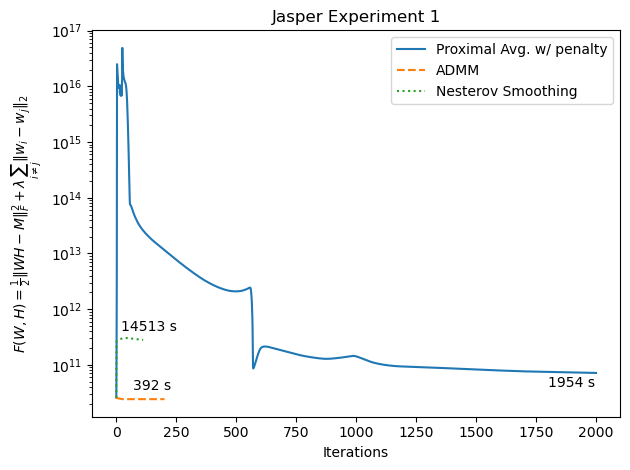

In [44]:
save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'
_, _, fscores, gscores, _, total_scores = load_results(save_filepath)
# total_scores = fscores + _lam * gscores
plt.plot(total_scores, linech[0])
# plt.plot(total_scores[np.insert(np.abs(total_scores[1:] - total_scores[:-1]) / total_scores[:-1] >= 1e-6, 0, True)], linech[0])

for i in range(1, len(w_solvers)):
    w_solver = w_solvers[i]
    save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solver}.npz'
    _, _, fscores, gscores, total_scores = load_results_old(save_filepath)
    plt.plot(total_scores, linech[i])
    # plt.plot(total_scores[np.insert(np.abs(total_scores[1:] - total_scores[:-1]) / total_scores[:-1] >= 1e-6, 0, True)], linech[i])



plt.yscale('log')
plt.legend(w_legend)
plt.xlabel('Iterations')
plt.ylabel(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2$')

plt.title('Jasper Experiment 1')
plt.text(1800, 10**11 * 0.4, '1954 s')
# plt.text(1800, 10**11 * 2, '2598 s')
plt.text(70, 10**11 * 0.35, '392 s')
plt.text(20, 10**11 * 4, '14513 s')

plt.tight_layout()
# plt.savefig(f'F_clipped_{dataset_name}.pdf', bbox_inches='tight')


## jasper full

In [ ]:
data_filepath = '../datasets/jasper_full.npz'
ini_filepath = '../saved_models/jasper_full/r{}_ini.npz'

In [ ]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape

In [ ]:
dataset_name = 'jasper_full'
m, n = M.shape
r = 20

max_iters = 1000
_lam = 1000000
_gamma = 1000000

In [ ]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [ ]:
# Proximal averaging with penalty term

save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'

if not os.path.exists(save_filepath):
    start_time = time.time()
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, max_minutes=600, W_update_iters=10, early_stop=True, verbose=False)
    time_taken = time.time() - start_time
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

    with open(csv_filename, 'a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([dataset_name , w_solvers[0], time_taken, save_filepath])

In [ ]:
for w_solver in w_solvers[1:]:
    save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solver}.npz'

    if not os.path.exists(save_filepath):
        start_time = time.time()
        W, H, fscores, gscores, total_scores = sonnmf_old(M, ini_W.copy(), ini_H.copy(), lam=_lam, w_update_method=w_solver, itermax=max_iters, max_minutes=600, W_update_iters=10, early_stop=True, verbose=False)
        time_taken = time.time() - start_time
        save_results_old(save_filepath, W, H, fscores, gscores, total_scores)

        with open(csv_filename, 'a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([dataset_name , w_solver, time_taken, save_filepath])

In [ ]:
# save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'
# _, _, fscores, gscores, _, total_scores = load_results(save_filepath)
# total_scores = fscores + _lam * gscores
# plt.plot(total_scores, linech[0])
# # plt.plot(total_scores[np.insert(np.abs(total_scores[1:] - total_scores[:-1]) / total_scores[:-1] >= 1e-6, 0, True)], linech[0])

# for i in range(1, len(w_solvers)):
#     w_solver = w_solvers[i]
#     save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solver}.npz'
#     _, _, fscores, gscores, total_scores = load_results_old(save_filepath)
#     plt.plot(total_scores, linech[i])
#     # plt.plot(total_scores[np.insert(np.abs(total_scores[1:] - total_scores[:-1]) / total_scores[:-1] >= 1e-6, 0, True)], linech[i])



# plt.yscale('log')
# plt.legend(w_legend)
# plt.xlabel('Iterations')
# plt.ylabel(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2$')

# plt.title('Jasper Experiment 1')
# plt.text(1800, 10**11 * 0.4, '1954 s')
# # plt.text(1800, 10**11 * 2, '2598 s')
# plt.text(70, 10**11 * 0.35, '392 s')
# plt.text(20, 10**11 * 4, '14513 s')

# plt.tight_layout()
# plt.savefig(f'F_clipped_{dataset_name}.pdf', bbox_inches='tight')


## urban full

In [ ]:
data_filepath = '../datasets/urban_full.npz'
ini_filepath = '../saved_models/urban_full/r{}_ini.npz'

In [ ]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape

In [ ]:
dataset_name = 'urban_full'
m, n = M.shape
r = 20

max_iters = 1000
_lam = 1000000
_gamma = 1000000

In [ ]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [ ]:
# Proximal averaging with penalty term

save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'

if not os.path.exists(save_filepath):
    start_time = time.time()
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, max_minutes=1440, W_update_iters=10, early_stop=True, verbose=False)
    time_taken = time.time() - start_time
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

    with open(csv_filename, 'a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([dataset_name , w_solvers[0], time_taken, save_filepath])

In [ ]:
for w_solver in w_solvers[1:]:
    save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solver}.npz'

    if not os.path.exists(save_filepath):
        start_time = time.time()
        W, H, fscores, gscores, total_scores = sonnmf_old(M, ini_W.copy(), ini_H.copy(), lam=_lam, w_update_method=w_solver, itermax=max_iters, max_minutes=1440, W_update_iters=10, early_stop=True, verbose=False)
        time_taken = time.time() - start_time
        save_results_old(save_filepath, W, H, fscores, gscores, total_scores)

        with open(csv_filename, 'a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([dataset_name , w_solver, time_taken, save_filepath])

In [ ]:
# save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solvers[0]}.npz'
# _, _, fscores, gscores, _, total_scores = load_results(save_filepath)
# total_scores = fscores + _lam * gscores
# plt.plot(total_scores, linech[0])
# # plt.plot(total_scores[np.insert(np.abs(total_scores[1:] - total_scores[:-1]) / total_scores[:-1] >= 1e-6, 0, True)], linech[0])

# for i in range(1, len(w_solvers)):
#     w_solver = w_solvers[i]
#     save_filepath = f'../saved_models/runtime_comparison/{dataset_name}_{w_solver}.npz'
#     _, _, fscores, gscores, total_scores = load_results_old(save_filepath)
#     plt.plot(total_scores, linech[i])
#     # plt.plot(total_scores[np.insert(np.abs(total_scores[1:] - total_scores[:-1]) / total_scores[:-1] >= 1e-6, 0, True)], linech[i])



# plt.yscale('log')
# plt.legend(w_legend)
# plt.xlabel('Iterations')
# plt.ylabel(r'$F(W, H) = \frac{1}{2} \| WH - M \|_F^2 + \lambda \sum_{i \neq j} \| w_i - w_j \|_2$')

# plt.title('Jasper Experiment 1')
# plt.text(1800, 10**11 * 0.4, '1954 s')
# # plt.text(1800, 10**11 * 2, '2598 s')
# plt.text(70, 10**11 * 0.35, '392 s')
# plt.text(20, 10**11 * 4, '14513 s')

# plt.tight_layout()
# plt.savefig(f'F_clipped_{dataset_name}.pdf', bbox_inches='tight')
